<a href="https://colab.research.google.com/github/pratikiiitb2013/Amplify_Demo/blob/main/Dell_AmplifyProgram_NLP_NN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel('/content/dici_with_levels - Main training dataset.xlsx')

df['OPP_NM_cleanUp'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.OPP_NM]
df['OPP_NM_cleanUp'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.OPP_NM_cleanUp]
df['OPP_NM_cleanUp'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.OPP_NM_cleanUp]

df['SLTN_NM_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_NM_DESC]

df['SLTN_TYPE_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_TYPE_DESC]

df['DELL_ACCT_NAME'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.DELL_ACCT_NAME]

df.OPP_NM_cleanUp = df.OPP_NM_cleanUp.replace('\s+', ' ', regex=True)
df.SLTN_NM_DESC = df.SLTN_NM_DESC.replace('\s+', ' ', regex=True)
df.SLTN_TYPE_DESC = df.SLTN_TYPE_DESC.replace('\s+', ' ', regex=True)
df.DELL_ACCT_NAME = df.DELL_ACCT_NAME.replace('\s+', ' ', regex=True)

df['OPP_NM_cleanUp'] = df['OPP_NM_cleanUp'].str.lower()
df['SLTN_NM_DESC'] = df['SLTN_NM_DESC'].str.lower()
df['SLTN_TYPE_DESC'] = df['SLTN_TYPE_DESC'].str.lower()
df['DELL_ACCT_NAME'] = df['DELL_ACCT_NAME'].str.lower()

df['FLG'] = df.apply(lambda x: x.DELL_ACCT_NAME in x.OPP_NM_cleanUp, axis=1)
df['Combined_OPP_NM_ACC_NM'] = np.where(df['FLG']==False, df['OPP_NM_cleanUp'] + ' ' + df['DELL_ACCT_NAME'], df['OPP_NM_cleanUp'])
df['final_combined'] = df['Combined_OPP_NM_ACC_NM'] + " " + df['SLTN_NM_DESC'].fillna('') + " " + df['SLTN_TYPE_DESC'].fillna('')
df.final_combined = df.final_combined.replace('\s+', ' ', regex=True)



In [ ]:
df.dici_Yes_No.value_counts()

In [3]:
import random
import torch, torchtext
from torchtext.legacy import data
SEED = 43
torch.manual_seed(SEED)

In [4]:
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

In [5]:
fields = [('text', TEXT),('label',LABEL)]
example = [data.Example.fromlist([df.final_combined[i],df.dici_Yes_No[i]], fields) for i in range(df.shape[0])] 
textDataset = data.Dataset(example, fields)
(train, valid) = textDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))


In [ ]:
print(f'Number of training examples: {len(train)}')
print(f'Number of testing examples: {len(valid)}')

print(vars(train.examples[0]))

In [6]:
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:23<00:00, 17133.01it/s]


#Embeddings
Helps in capturing contexual information and relationship between words
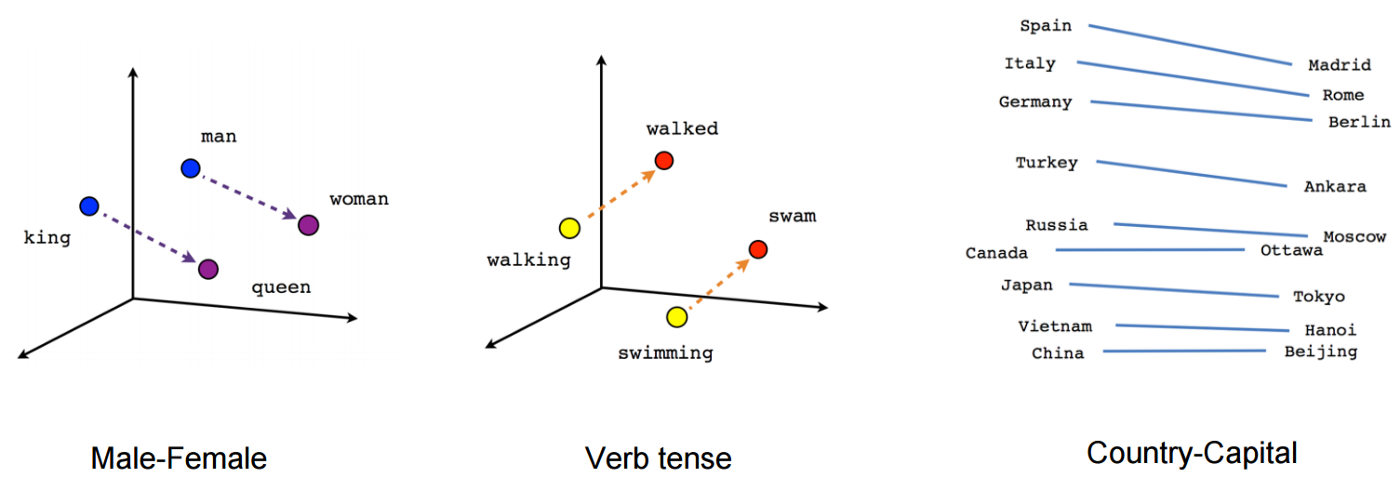

#Example

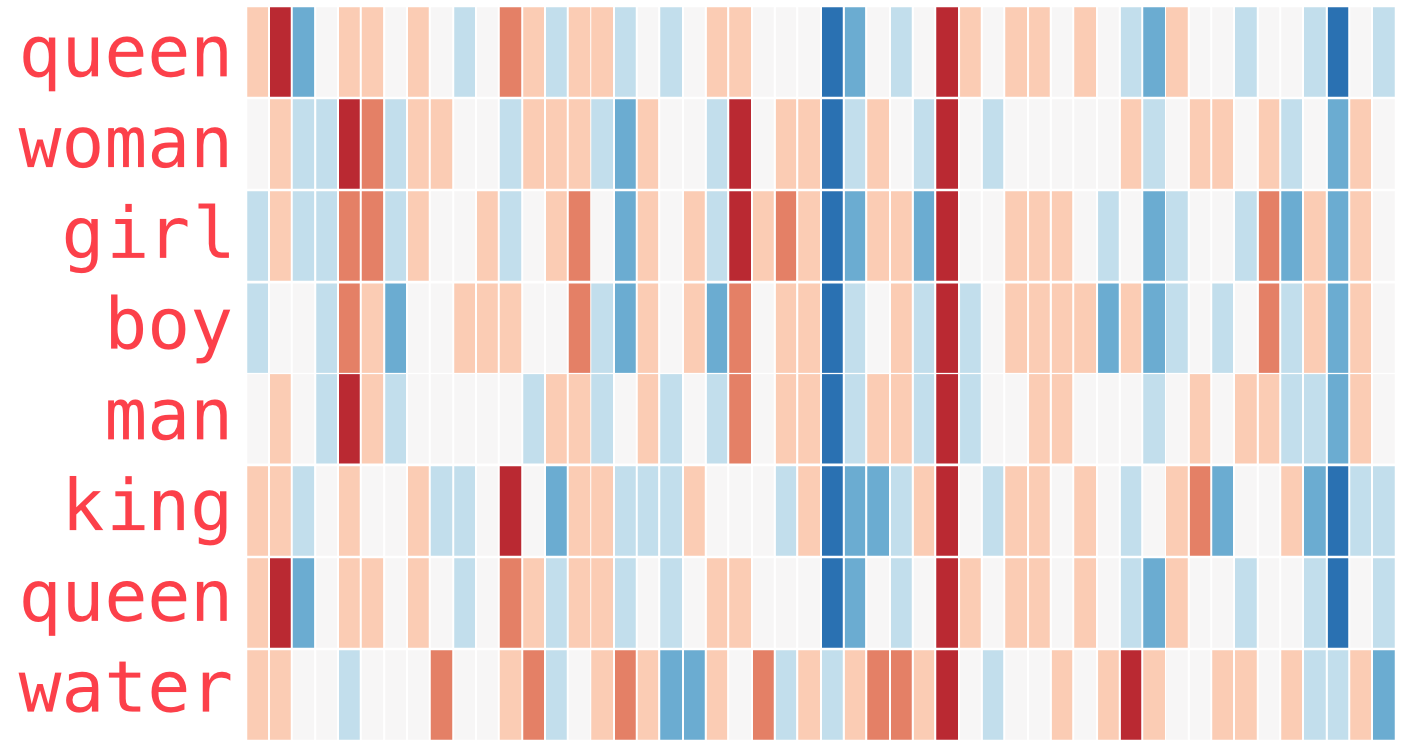

### <li> We can see how “woman” and “girl” are similar to each other in a lot of places. The same with “man” and “boy”.
### <li>“boy” and “girl” also have places where they are similar to each other, but different from “woman” or “man”. These can be coding for concept of youth.

### <li>All but the last word are words representing people. We can see that blue column going all the way down and stopping before the embedding for “water”.
### <li>There are clear places where “king” and “queen” are similar to each other and distinct from all the others. These can be coding for a concept of royalty.


## We are also expecting to be able to do something like this -
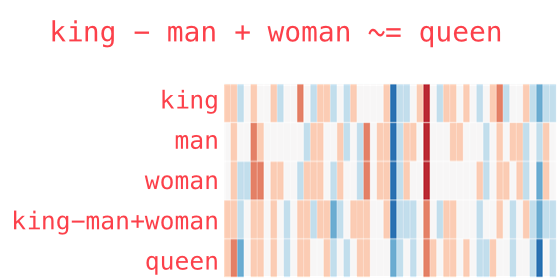

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print('Top 10 words appreared repeatedly :', list(TEXT.vocab.freqs.most_common(20)))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

In [7]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train, valid), 
    batch_size = BATCH_SIZE,
    sort=False,
    device = device)

cuda


In [8]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(TEXT.vocab.stoi, tokens)

In [9]:
import torch.nn as nn

class classifier(nn.Module):
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        #text = [sent len, batch size]
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

In [10]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = 7
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
# print(pad_idx)
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, pad_idx)
print(model)


classifier(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)


In [11]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,593,647 trainable parameters


In [12]:
pretrained_embeddings = TEXT.vocab.vectors
# print(pretrained_embeddings.shape)

In [13]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.6604e-02, -4.6679e-01,  2.0909e+00,  ..., -1.4692e+00,
          4.4764e-01, -7.2234e-01],
        [-7.9055e-02, -2.0895e-01, -3.4423e-01,  ...,  4.6572e-01,
          6.2975e-01, -1.7395e+00],
        [-9.8863e-01,  2.7295e-01, -2.7247e-01,  ...,  5.3261e-04,
         -2.3852e-03,  3.4945e-01],
        ...,
        [ 2.7770e-01, -1.8895e-01, -4.9623e-01,  ..., -3.1067e-01,
         -8.4584e-01, -4.4045e-02],
        [-1.2849e+00,  4.2994e-01,  2.9515e-01,  ..., -9.9547e-01,
          1.8987e-01, -8.4108e-01],
        [ 9.5664e-02, -3.8580e-01, -2.9071e-01,  ...,  9.3856e-02,
         -4.2107e-01, -8.2397e-02]])

In [14]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

# print(model.embedding.weight.data)

In [15]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [16]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [17]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()  
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 10
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.349 | Train Acc: 45.62%
	 Val. Loss: 1.182 |  Val. Acc: 50.46%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.995 | Train Acc: 63.95%
	 Val. Loss: 0.940 |  Val. Acc: 64.92%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.105 | Train Acc: 58.57%
	 Val. Loss: 1.050 |  Val. Acc: 60.05%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.951 | Train Acc: 69.40%
	 Val. Loss: 1.469 |  Val. Acc: 34.49%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 1.056 | Train Acc: 62.54%
	 Val. Loss: 0.994 |  Val. Acc: 65.42%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.989 | Train Acc: 66.54%
	 Val. Loss: 0.857 |  Val. Acc: 76.01%
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.790 | Train Acc: 77.81%
	 Val. Loss: 0.813 |  Val. Acc: 77.53%
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.912 | Train Acc: 68.92%
	 Val. Loss: 0.743 |  Val. Acc: 79.20%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.669 | Train Acc: 81.39%
	 Val. Loss: 0.668 |  Val. Acc: 81.30%
Epoch: 10 | Epoch Time: 0m 8